[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
import os
from dotenv import load_dotenv

load_dotenv(os.path.join(os.path.abspath(os.path.join(os.getcwd(), "..")), ".env"))

os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'

os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

## Messages as state

First, let's define some messages.

In [2]:
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4.1")
llm.invoke(messages)

AIMessage(content='Great question! Whales are definitely a major group, but "ocean mammals" (also called **marine mammals**) include several different kinds. Here are the main groups you should consider:\n\n### 1. **Dolphins and Porpoises**\n- **Dolphins** (like the bottlenose dolphin) are closely related to whales, part of the cetacean group. \n- **Porpoises** look similar to dolphins but are generally smaller and have different shaped teeth and fins.\n\n### 2. **Seals, Sea Lions, and Walruses** (**Pinnipeds**)\n- **Seals**: Like harbor seals and leopard seals. Seals have small flippers and move awkwardly on land.\n- **Sea lions and fur seals**: Have larger, rotating flippers and can "walk" on land.\n- **Walrus**: Known for their tusks and large size, live in Arctic areas.\n\n### 3. **Manatees and Dugongs** (**Sirenians**)\n- Also called "sea cows."\n- Manatees are found in the Atlantic (Florida, Caribbean, West Africa).\n- Dugongs live in coastal waters of the Indian and western Paci

We can run our chat model in a simple graph with `MessagesState`.

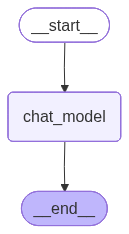

In [5]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Absolutely! Whales are just one group of ocean mammals, collectively known as **marine mammals**. If you want a broader understanding, here are some main groups and examples to consider:

## 1. **Dolphins and Porpoises (Order: Cetacea)**
- **Dolphins:** Bottlenose dolphin, common dolphin, orca (killer whale*)
- **Porpoises:** Harbor porpoise, vaquita

(\*Orcas are actually dolphins!)

## 2. **Seals, Sea Lions, and Walruses (Order: Pinnipedia)**
- **Seals:** Harbor seal, leopard seal, elephant seal
- **Sea Lions:** California sea lion, Steller sea lion
- **Walrus:** Only one species, found in the Arctic

## 3. **M

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

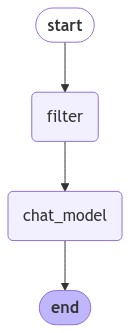

In [7]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

`MessagesState` 在接收到 `{"messages": delete_messages}` 返回值后，会自动调用类似 `add_messages()` 的机制来管理状态中的消息列表。当 `delete_messages` 包含 `RemoveMessage` 对象时，系统会删除对应ID的消息，因此下一个节点只会接收到保留的最新两条消息。

In [7]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That’s awesome! Besides whales, here are several fascinating ocean mammals you might want to learn about:

### 1. **Dolphins**
- **Types**: Bottlenose, common, spinner, and many more.
- **Fun Fact**: Highly intelligent, use echolocation, and exhibit complex social behaviors.

### 2. **Porpoises**
- **Difference from dolphins**: Generally smaller, have shorter snouts, and different shaped teeth.
- **Species**: Harbor porpoi

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

关键区别：第一种方法使用 RemoveMessage 永久删除历史消息，状态中的消息数量会减少；第二种方法只是在调用 LLM 时传入最后一条消息，但完整的消息历史仍保存在状态中。第一种是状态级别的消息管理，第二种是调用级别的消息筛选。

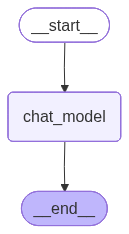

In [8]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [9]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [10]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That’s awesome! Besides whales, here are several fascinating ocean mammals you might want to learn about:

### 1. **Dolphins**
- **Types**: Bottlenose, common, spinner, and many more.
- **Fun Fact**: Highly intelligent, use echolocation, and exhibit complex social behaviors.

### 2. **Porpoises**
- **Difference from dolphins**: Generally smaller, have shorter snouts, and different shaped teeth.
- **Species**: Harbor porpoi

In [14]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great that you know about whales! There are many other fascinating ocean mammals you can learn about. Here are a few:

1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and sophisticated communication skills. There are many species of dolphins, including the well-known bottlenose dolphin.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and ha

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.



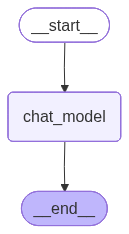

In [ ]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
        # trim_messages() 只是在消息传入模型之前进行截断处理, 原始的 state["messages"] 保持完整不变
        # 不同模型使用不同的编码器
        # model_encodings = {
        #     "gpt-4": "cl100k_base",
        #     "gpt-4o": "o200k_base", 
        #     "gpt-4o-mini": "o200k_base",
        #     "gpt-3.5-turbo": "cl100k_base",
        # }
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"), # tiktoken 在本地进行计算
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [20]:
# Example of trimming messages
trim_messages(
            messages, # 要截断的消息列表
            max_tokens=40, # 最大 token 数量限制
            strategy="last", # 截断策略
            token_counter=ChatOpenAI(model="gpt-4o"), # token 计算器
            allow_partial=True # 是否允许部分消息截断
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [21]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r